Linear Models
====

Find patterns in the completion rate

In [85]:
"""
Create a dataframe that we'll fit to

"""

from analysis_utils import clean

meal_info = clean.cleaned_smartwatch(keep_catchups=False, keep_day0=False)

In [86]:
import pandas as pd

completion_df = pd.DataFrame()

# Participant ID, entry day and meal type
completion_df["p_id"] = meal_info["p_id"]
completion_df["day"] = meal_info["delta"].dt.days
completion_df["meal_type"] = meal_info["meal_type"]

In [87]:
# Demographic information
from analysis_utils import clean

demographic_df = clean.cleaned_survey()
demographic_df = demographic_df[
    [
        "residents_id",
        "respondent_sex",
        "respondent_ethnicity",
        "age_dob",
        "phyactq1",  # In the last 7 days, how many days did you attend school?
        "smart1_7to9",  # Did your child participate in the smartwatch study?
        "smart1_10to17",  # Did you participate in the smartwatch study?
    ]
]

In [88]:
completion_df = (
    completion_df.reset_index()
    .merge(demographic_df, left_on="p_id", right_on="residents_id", how="left")
    .set_index(completion_df.index)
)

In [89]:
# Keep only participants who wore the smartwatch
keep = (completion_df["smart1_7to9"] == 1) | (completion_df["smart1_10to17"] == 1)
print(f"Keeping {len(completion_df.loc[keep, 'p_id'].unique())} participants")

completion_df = completion_df.loc[keep]

Keeping 82 participants


In [90]:
# Convert sex to 0 or 1 (insead of 1 or 2) for male/female respectively
completion_df["respondent_sex"] -= 1

In [91]:
# Whether each entry was a response or not
completion_df["entry"] = (
    completion_df["meal_type"]
    .isin({"Meal", "Drink", "Snack", "No food/drink"})
    .astype(int)
)

In [92]:
completion_df.rename(
    columns={"respondent_sex": "sex", "respondent_ethnicity": "ethnicity"},
    inplace=True,
)

In [ ]:
"""
We only really care about the number of prompts and responses per day

"""

In [93]:
completion_df.to_csv("outputs/data/completion.csv", index=False)

In [94]:
"""
Launch a script that compares several day models

"""

import subprocess

subprocess.run(["Rscript", "analysis_utils/r/completion_model.R"], check=True)

Loading required package: Matrix
Warning message:
package ‘Matrix’ was built under R version 4.3.2 
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning messages:
1: package ‘dplyr’ was built under R version 4.3.2 
2: package ‘stringr’ was built under R version 4.3.2 
Learn more about sjPlot with 'browseVignettes("sjPlot")'.

Attaching package: ‘scales’

The following object is masked from ‘packag

[1] -0.04665179
[1] 0.04072158


CompletedProcess(args=['Rscript', 'analysis_utils/r/completion_model.R'], returncode=0)

In [95]:
"""
Convert the coefficient in the fit to an approximate drop-off per day

"""

# Read the coefficient from the output file
out_file = "outputs/imgs/completion/compare_models/day_models.txt"

# Find the slope
with open(out_file) as f:
    # Find lines starting with "day" since they contain our results
    matches = [line.strip() for line in f.readlines() if line.startswith("day")]

    # Choose the right one
    match = matches[-2]

slope, err = (float(x) for x in match.split()[1:3])
slope, err

(-0.25632, 0.03791)

In [96]:
"""
Get the intercept and its error

"""

# Should really read this from file but it's easier to just hard-code it
intercept, int_err = 1.79175, 0.13919

In [97]:
# From the fit parameters find the approximate drop off per day
# We'll need to bootstrap do do this,
# as it depends on the intercept and the slope which both have an associated uncertainty
import numpy as np
from scipy.stats import multivariate_normal


def logodds2deltaprob(intercept, slope):
    """Convert a slope and intercept to a drop-off per day"""
    probs = [1 / (1 + np.exp(-(intercept + slope * day))) for day in range(1, 8)]
    changes = [probs[i] - probs[i - 1] for i in range(1, 7)]
    return 100 * sum(changes) / len(changes)


# Find a covariance matrix for our fit
errs = np.array([int_err, err])
correlations = np.array(
    [
        (1.0, -0.555),
        (-0.555, 1.0),
    ]
)
covariance = np.outer(errs, errs) * correlations

# Draw lots of random values for the slope and intercept
rng = np.random.default_rng(0)
n_boot = 25_000_000
rvs = rng.multivariate_normal(
    [intercept, slope],
    covariance,
    n_boot,
)


# Find the drop off per day in each case
dropoffs = logodds2deltaprob(*rvs.T)

# Find the mean and 95%CI
print(dropoffs.mean(), np.quantile(dropoffs, [0.025, 0.975]))

-5.378379003628384 [-7.12032765 -3.63509251]


In [98]:
""" Find the completion on day 1"""
day1_completion = rvs[:, 0] # rvs.sum(axis=1)

# Convert from log odds to probability
day1_completion = 1 / (1 + np.exp(-day1_completion))
np.mean(day1_completion), np.percentile(day1_completion, [2.5, 97.5])

(0.8562969974257105, array([0.82037947, 0.88741516]))

In [99]:
"""
Launch a script that compares male and female entry rates

"""

subprocess.run(["Rscript", "analysis_utils/r/completion_sex.R"], check=True)

Loading required package: Matrix
Warning message:
package ‘Matrix’ was built under R version 4.3.2 
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning messages:
1: package ‘dplyr’ was built under R version 4.3.2 
2: package ‘stringr’ was built under R version 4.3.2 

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked fro

CompletedProcess(args=['Rscript', 'analysis_utils/r/completion_sex.R'], returncode=0)

In [100]:
"""
Find the odds ratio and probability

"""

intercept = 1.45221
sex_coef = 0.52504
day_coef = -0.29669

# Calculate the probability at day 1
male_logodds = intercept + day_coef
female_logodds = intercept + sex_coef + day_coef

# Convert intercepts to probabilities
prob_males = 1 / (1 + np.exp(-male_logodds))
prob_females = 1 / (1 + np.exp(-female_logodds))

prob_males, prob_females

(0.7605177226867417, 0.8429786701061789)

In [101]:
"""
Use bootstrap resampling to find the 95% confidence interval

"""

coeffs = np.array([intercept, day_coef, sex_coef])
errs = np.array([0.22459, 0.06328, 0.28181])
correlations = np.array(
    [
        [1.000, -0.591, -0.795],
        [-0.591, 1.000, 0.469],
        [-0.795, 0.469, 1.000],
    ]
)
covariance = np.outer(errs, errs) * correlations

day = 1

# Generate random intercepts, day coefficients and sex coefficients
n_boot = 25_000_000
bootstrap_samples = multivariate_normal.rvs(mean=coeffs, cov=covariance, size=n_boot)
intercepts = bootstrap_samples[:, 0]
day_coefs = bootstrap_samples[:, 1]
sex_coefs = bootstrap_samples[:, 2]

# Find male and female probabilities for each
male_probs = 1 / (1 + np.exp(-(intercepts + day * day_coefs)))
female_probs = 1 / (1 + np.exp(-(intercepts + sex_coefs + day * day_coefs)))

diff = female_probs - male_probs
print(100 * diff.mean(), 100 * np.percentile(diff, [2.5, 97.5]))

8.273326967505719 [-0.42505857 17.33960851]


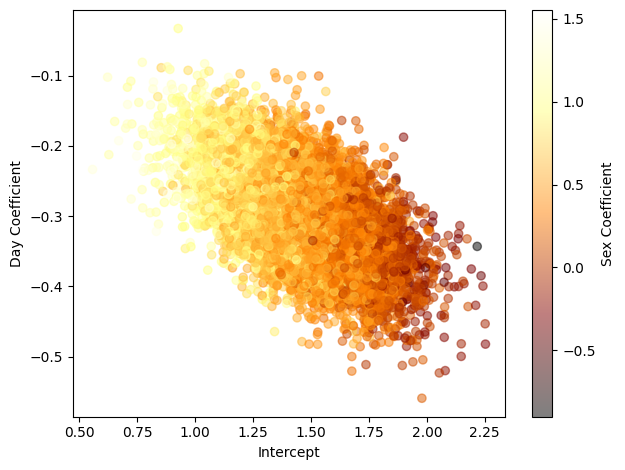

In [102]:
"""
Plot the coefficients

Use a 2d scatter plot for intercept and day coef,  where the colour bar shows the sex coef

"""

import matplotlib.pyplot as plt

fig, axis = plt.subplots()

# only plot a subset
N = 10000

sc = axis.scatter(
    bootstrap_samples[:, 0][:N],
    bootstrap_samples[:, 1][:N],
    c=bootstrap_samples[:, 2][:N],
    cmap="afmhot",
    alpha=0.5,
)

axis.set_xlabel("Intercept")
axis.set_ylabel("Day Coefficient")

cbar = fig.colorbar(sc)
cbar.set_label("Sex Coefficient")

fig.tight_layout()
fig.savefig("outputs/imgs/coeffs.png")

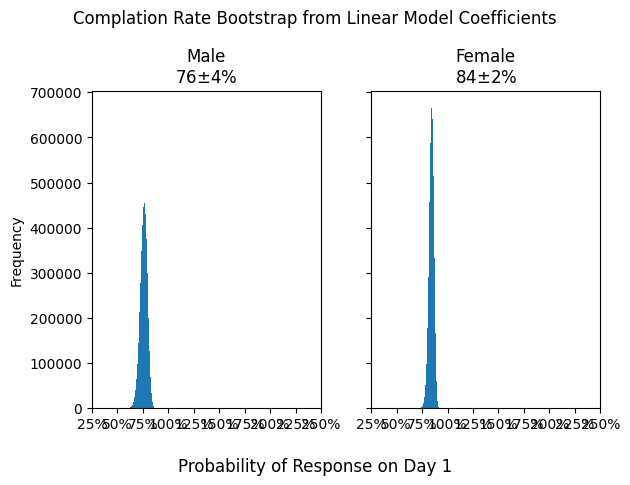

In [103]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
bins = np.linspace(0.55, 0.95, 250)

axes[0].hist(male_probs, bins=bins)
axes[1].hist(female_probs, bins=bins)

axes[0].set_title(
    f"Male\n{100 * np.mean(male_probs):.0f}$\pm${100 * np.std(male_probs):.0f}%"
)
axes[1].set_title(
    f"Female\n{100 * np.mean(female_probs):.0f}$\pm${100 * np.std(female_probs):.0f}%"
)


axes[0].set_ylabel("Frequency")
axes[0].set_xticks(axis.get_xticks(), [f"{x:.0%}" for x in axis.get_xticks()])
fig.supxlabel(f"Probability of Response on Day {day}")
fig.suptitle("Complation Rate Bootstrap from Linear Model Coefficients")

fig.tight_layout()
fig.savefig("outputs/imgs/bootstrap_probs.png")

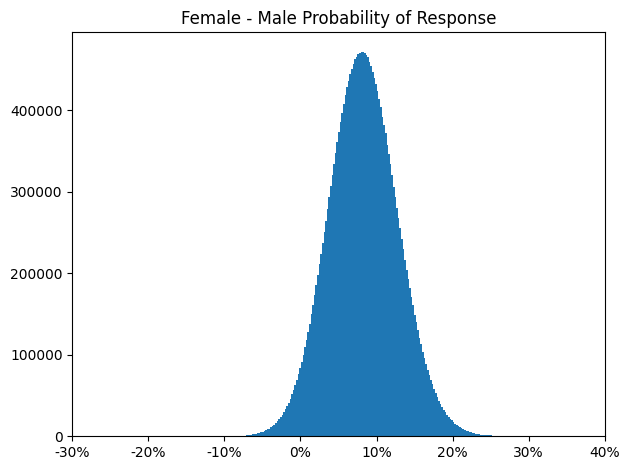

In [104]:
""" Plot the diff """

fig, axis = plt.subplots()

axis.hist(diff, bins=250)

axis.set_title("Female - Male Probability of Response")
axis.set_xticks(axis.get_xticks(), [f"{x:.0%}" for x in axis.get_xticks()])

fig.tight_layout()
fig.savefig("outputs/imgs/bootstrap_diff.png")

Compliance Rate
----

In [105]:
"""
Make a dataframe holding participant ID, sex and number of entries on each day

"""

from itertools import product


def collapse_meal_info(meal_df: pd.DataFrame, delta: pd.Timedelta) -> pd.DataFrame:
    collapsed_meal_info = pd.DataFrame()

    for _, group in meal_df.groupby("p_id"):
        assert group.index.is_monotonic_increasing

        # Mark which ones are near enough each other to be considered the same
        n_entries = len(group)
        keep = np.ones(n_entries, dtype=bool)

        for i in range(1, n_entries):
            if (group.index[i] - group.index[i - 1] < delta) and (
                group["entry"].iloc[i] == group["entry"].iloc[i - 1]
            ):
                keep[i] = False

        # Append to the new dataframe
        collapsed_meal_info = pd.concat([collapsed_meal_info, group[keep]])

    return collapsed_meal_info


# Read meal info
meal_info = clean.cleaned_smartwatch(keep_catchups=False, keep_day0=False)
meal_info["entry"] = meal_info["meal_type"].isin(
    {"Meal", "Drink", "Snack", "No food/drink"}
)

# Keep only positive entries
meal_info = meal_info[meal_info["entry"]]

# Collapse nearby entries
time_cutoff = 27
meal_info = collapse_meal_info(meal_info, pd.Timedelta(minutes=time_cutoff))

In [106]:
compliance_df = pd.DataFrame(
    list(product(meal_info["p_id"].unique(), range(1, 8))), columns=["p_id", "day"]
)
compliance_df["n_entries"] = 0
compliance_df = compliance_df.merge(
    demographic_df[["respondent_sex", "residents_id"]],
    left_on="p_id",
    right_on="residents_id",
    how="left",
)
compliance_df["respondent_sex"] -= 1
compliance_df

,p_id,day,n_entries,respondent_sex,residents_id
0,141,1,0,1.0,141
1,141,2,0,1.0,141
2,141,3,0,1.0,141
3,141,4,0,1.0,141
4,141,5,0,1.0,141
...,...,...,...,...,...
569,39930,3,0,1.0,39930
570,39930,4,0,1.0,39930
571,39930,5,0,1.0,39930
572,39930,6,0,1.0,39930


In [107]:
# Count the number of entries for each participant on each day
for _, row in meal_info.iterrows():
    compliance_df.loc[
        (compliance_df["p_id"] == row["p_id"])
        & (compliance_df["day"] == row["delta"].days),
        "n_entries",
    ] += 1

compliance_df["n_entries"].sum()
compliance_df

,p_id,day,n_entries,respondent_sex,residents_id
0,141,1,8,1.0,141
1,141,2,10,1.0,141
2,141,3,9,1.0,141
3,141,4,7,1.0,141
4,141,5,10,1.0,141
...,...,...,...,...,...
569,39930,3,10,1.0,39930
570,39930,4,9,1.0,39930
571,39930,5,8,1.0,39930
572,39930,6,5,1.0,39930


In [108]:
compliance_df["compliance_rate"] = compliance_df["n_entries"] / 12

In [109]:
compliance_df.to_csv("outputs/data/compliance.csv", index=False)

In [110]:
"""
Run linear model for compliance rate vs day

"""

subprocess.run(["Rscript", "analysis_utils/r/compliance_model.R"], check=True)

Loading required package: Matrix
Warning message:
package ‘Matrix’ was built under R version 4.3.2 
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning messages:
1: package ‘dplyr’ was built under R version 4.3.2 
2: package ‘stringr’ was built under R version 4.3.2 

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked fro

CompletedProcess(args=['Rscript', 'analysis_utils/r/compliance_model.R'], returncode=0)

In [111]:
"""
Find the significance of the drop off in compliance rate

"""

# Don't need to do anything clever, since it's a linear model
# But we might as well bootstrap to get the 95% CI; it should be the same as in the value in compliance_summary.txt
intercept, day_coef = 0.756823, -0.051866
intercept_err, day_err = 0.031689, 0.006938
coeffs = np.array([intercept, day_coef])
errs = np.array([intercept_err, day_err])
correlations = np.array(
    [
        [1.000, -0.544],
        [-0.544, 1.000],
    ]
)
covariance = np.outer(errs, errs) * correlations

n_boot = 25_000_000
rvs = rng.multivariate_normal(
    coeffs,
    covariance,
    n_boot,
)


# Find the drop off per day in each case
_, dropoffs = rvs.T

# Find the mean and 95%CI
print(dropoffs.mean(), np.quantile(dropoffs, [0.025, 0.975]))

-0.051865387649603516 [-0.06545622 -0.03826054]


In [112]:
""" Find the average and uncertainty on day 1 """
day1_compliance = rvs[:, 0] # rvs.sum(axis=1)
np.mean(day1_compliance), np.percentile(day1_compliance, [2.5, 97.5])

(0.7568124245314811, array([0.69468774, 0.81894087]))

In [61]:
"""
Run linear model for compliance rate vs day with sex as a covariate

"""

subprocess.run(["Rscript", "analysis_utils/r/compliance_sex.R"], check=True)

Loading required package: Matrix
Warning message:
package ‘Matrix’ was built under R version 4.3.2 
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning messages:
1: package ‘dplyr’ was built under R version 4.3.2 
2: package ‘stringr’ was built under R version 4.3.2 
Install package "strengejacke" from GitHub (`devtools::install_github("strengejacke/strengejacke")`) to load all sj-packages at onc

CompletedProcess(args=['Rscript', 'analysis_utils/r/compliance_sex.R'], returncode=0)

In [62]:
import numpy as np
from scipy.stats import multivariate_normal

# Intercept day sex
coeffs = np.array([0.643651, -0.050992, 0.178465])
errs = np.array([0.050265, 0.011541, 0.063121])
correlations = np.array(
    [
        [1.000, -0.568, -0.796],
        [-0.568, 1.000, 0.452],
        [-0.796, 0.452, 1.000],
    ]
)
covariance = np.outer(errs, errs) * correlations

day = 1

n_boot = 1_000_000
# Generate random intercepts, day coefficients and sex coefficients
bootstrap_samples = multivariate_normal.rvs(mean=coeffs, cov=covariance, size=n_boot)
intercepts = bootstrap_samples[:, 0]
day_coefs = bootstrap_samples[:, 1]
sex_coefs = bootstrap_samples[:, 2]

# Find male and female probabilities for each
male_probs = intercepts + day * day_coefs
female_probs = intercepts + sex_coefs + day * day_coefs

diff = female_probs - male_probs
print(100 * diff.mean(), 100 * np.percentile(diff, [2.5, 97.5]))

17.842717921009154 [ 5.48434958 30.19800211]


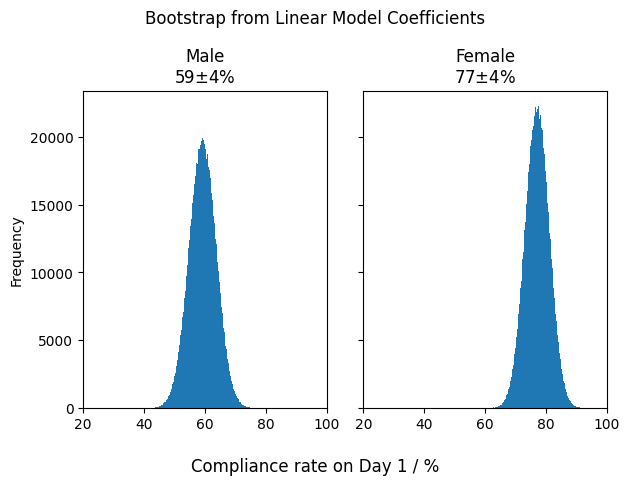

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, sharey=True, sharex=True)
bins = np.linspace(0.4, 0.95, 250)

axes[0].hist(male_probs, bins=bins)
axes[1].hist(female_probs, bins=bins)


axes[0].set_title(
    f"Male\n{100 * np.mean(male_probs):.0f}$\pm${100 * np.std(male_probs):.0f}%"
)

axes[1].set_title(
    f"Female\n{100 * np.mean(female_probs):.0f}$\pm${100 * np.std(female_probs):.0f}%"
)


axes[0].set_ylabel("Frequency")
fig.supxlabel(f"Compliance rate on Day {day} / %")
fig.suptitle("Bootstrap from Linear Model Coefficients")

for axis in axes:
    axis.set_xticks(
        axis.get_xticks(),
        [f"{100 * tick:.0f}" for tick in axis.get_xticks()],
        ha="center",
    )

fig.tight_layout()
fig.savefig("outputs/imgs/compliance_bootstrap_probs.png")

In [64]:
"""
Find the compliance rate for active participants

"""

# Again, find the number of responses for each participant on each day
meal_info = clean.cleaned_smartwatch(keep_catchups=False, keep_day0=False)
meal_info["entry"] = meal_info["meal_type"].isin(
    {"Meal", "Drink", "Snack", "No food/drink"}
)

meal_info = meal_info[meal_info["entry"]]

time_cutoff = 27
meal_info = collapse_meal_info(meal_info, pd.Timedelta(minutes=time_cutoff))

n_participants, n_days = len(meal_info["p_id"].unique()), 7
meal_info["delta_day"] = meal_info["delta"].dt.days


def active_days(entries: np.ndarray) -> int:
    return len(entries) - np.argmax(np.cumsum(entries[::-1]) > 0)


# Write a dataframe with p_id, day and compliance rate while active and
active_df = pd.DataFrame(columns=["p_id", "day", "active_compliance_rate"])

# Make a lookup table from p_id to sex
sex_lookup = (
    demographic_df.set_index("residents_id")["respondent_sex"]
    .apply(lambda x: x - 1)
    .to_dict()
)

for p_id, group in meal_info.groupby("p_id"):
    n_entries = np.zeros(n_days, dtype=int)
    for i, (delta, subgroup) in enumerate(group.groupby("delta_day")):
        n_entries[i] = len(subgroup["entry"])

    # Find how long this participant was active for
    n_days_active = active_days(n_entries)
    active_entries = n_entries[:n_days_active]

    for day, entry in enumerate(active_entries, start=1):
        # Find the compliance rate while active
        rate = entry / 12

        active_df = pd.concat(
            [
                active_df,
                pd.DataFrame(
                    {
                        "p_id": [p_id],
                        "day": [day],
                        "active_compliance_rate": [rate],
                        "sex": [sex_lookup[p_id]],
                    }
                ),
            ],
            ignore_index=True,
        )

active_df.to_csv("outputs/data/active_compliance.csv", index=False)

/tmp/ipykernel_1921/2352239740.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  active_df = pd.concat(


In [65]:
subprocess.run(["Rscript", "analysis_utils/r/active_compliance.R"], check=True)

Loading required package: Matrix
Warning message:
package ‘Matrix’ was built under R version 4.3.2 
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ tidyr::unpack() masks Matrix::unpack()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning messages:
1: package ‘dplyr’ was built under R version 4.3.2 
2: package ‘stringr’ was built under R version 4.3.2 
#refugeeswelcome

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following obj

CompletedProcess(args=['Rscript', 'analysis_utils/r/active_compliance.R'], returncode=0)

In [66]:
"""
Draw some random numbers to estimate the slope
"""

intercept, day_coef = 0.786432, -0.041406
intercept_err, day_err = 0.024351, 0.006193
coeffs = np.array([intercept, day_coef])
errs = np.array([intercept_err, day_err])
correlations = np.array(
    [
        [1.000, -0.14],
        [-0.14, 1.000],
    ]
)
covariance = np.outer(errs, errs) * correlations

n_boot = 25_000_000
rvs = rng.multivariate_normal(
    coeffs,
    covariance,
    n_boot,
)


# Find the drop off per day in each case
_, dropoffs = rvs.T

# Find the mean and 95%CI
print(dropoffs.mean(), np.quantile(dropoffs, [0.025, 0.975]))

-0.0414062509015704 [-0.05354214 -0.02926659]


In [67]:
""" Find the compliance for day 1 """
day1_compliance = rvs.sum(axis=1)
np.mean(day1_compliance), np.percentile(day1_compliance, [2.5, 97.5])

(0.7450216074155921, array([0.69744986, 0.79260912]))

In [ ]:
"""
Run the linear model for active compliance with sex as a covariate

"""
subprocess.run(["Rscript", "analysis_utils/r/active_compliance_sex.R"], check=True)

In [33]:
# Intercept day sex
coeffs = np.array([0.72121, -0.04869, 0.10236])
errs = np.array([0.04062, 0.01086, 0.05026])
correlations = np.array(
    [
        [1.000, -0.621, -0.808],
        [-0.621, 1.000, 0.502],
        [-0.808, 0.502, 1.000],
    ]
)
covariance = np.outer(errs, errs) * correlations

day = 1

n_boot = 1_000_000
# Generate random intercepts, day coefficients and sex coefficients
bootstrap_samples = multivariate_normal.rvs(mean=coeffs, cov=covariance, size=n_boot)
intercepts = bootstrap_samples[:, 0]
day_coefs = bootstrap_samples[:, 1]
sex_coefs = bootstrap_samples[:, 2]

# Find male and female probabilities for each
male_probs = intercepts + day * day_coefs
female_probs = intercepts + sex_coefs + day * day_coefs

diff = female_probs - male_probs
print(100 * diff.mean(), 100 * np.percentile(diff, [2.5, 97.5]))

10.237148283875971 [ 0.37747464 20.11482921]
